<a href="https://colab.research.google.com/github/aurshitha/AI-for-Medical-Diagnosis-using-Chest-X-rays/blob/main/Chest-X-Ray-Medical-Diagnosis-with-Deep-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow keras numpy pandas matplotlib opencv-python scikit-learn pydicom
# import neccessary packages
import tensorflow as tf
import keras
import sklearn
import pickle
import cv2
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.1 MB/s eta 0:00:00


In [4]:
!pip install kaggle
!pip install -q kaggle

In [5]:
from google.colab import files
files.upload()  # Select the downloaded `kaggle.json` file

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Set permissions

Saving kaggle.json to kaggle.json


In [6]:
# Verify the downloaded file name
!ls

ai_for_medical_diagnosis_fixed.py  sample_data


In [7]:
# List datasets to confirm it's working
!kaggle datasets list -s "nih chest x-ray"
# Replace with your actual dataset name
!kaggle datasets download -d nih-chest-xrays/sample
# Unzip it
!unzip sample.zip -d sample_chest_xray_data

Streaming output truncated to the last 5000 lines.
  inflating: sample_chest_xray_data/sample/sample/images/00003124_000.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_000.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_001.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_004.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_009.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_011.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003135_000.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003140_007.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003159_001.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003169_001.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003177_002.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003186_004.png  
  inflating: sample_chest_xray_data/s

In [45]:
# Load the metadata CSV
csv_path = ('sample_chest_xray_data/sample/sample_labels.csv')
df = pd.read_csv(csv_path)

# Preview basic info
print("Initial Dataset Shape:", df.shape)
print(df.head())
print(df.info())

Initial Dataset Shape: (5606, 11)
        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                30

In [14]:
# Step 2: Class Distribution Analysis
# Total normal vs abnormal
print("\nNormal vs Abnormal Case Counts:")
print(df['Is_Normal'].value_counts())


# Frequency of each disease
disease_counts = df[unique_diseases].sum().sort_values(ascending=False)
print("\nDisease Counts:\n", disease_counts)


Normal vs Abnormal Case Counts:
Is_Normal
1    3044
0    2562
Name: count, dtype: int64

Disease Counts:
 Infiltration          967
Effusion              644
Atelectasis           508
Nodule                313
Mass                  284
Pneumothorax          271
Consolidation         226
Pleural_Thickening    176
Cardiomegaly          141
Emphysema             127
Edema                 118
Fibrosis               84
Pneumonia              62
Hernia                 13
dtype: int64


/tmp/ipython-input-4169712728.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='magma')


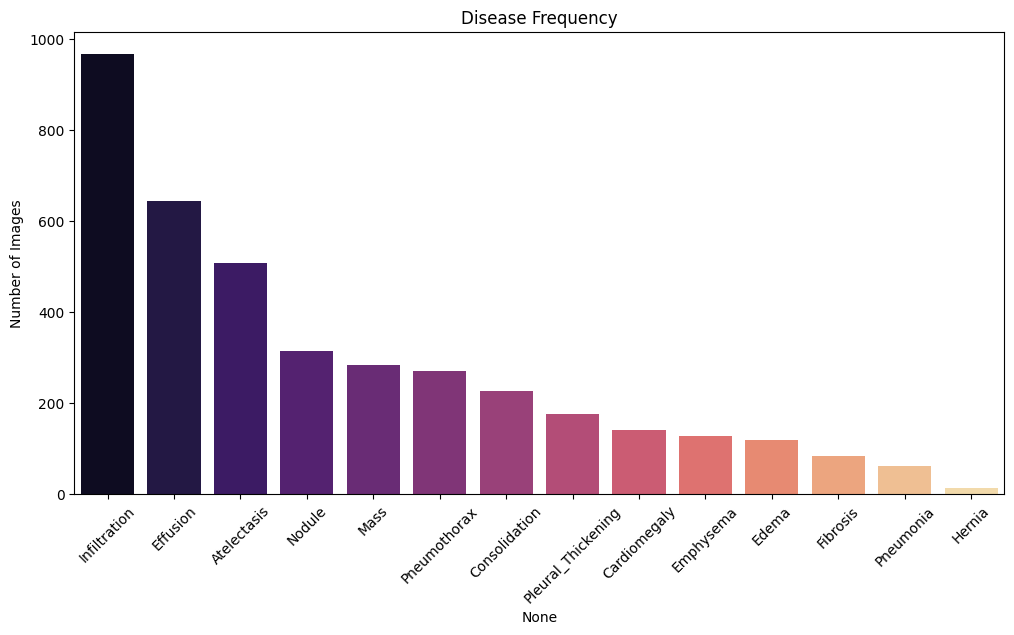


Multi-Label Distribution:
Num_Labels
1    4626
2     690
3     212
4      58
5      17
6       2
7       1
Name: count, dtype: int64


/tmp/ipython-input-4169712728.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values, palette='coolwarm')


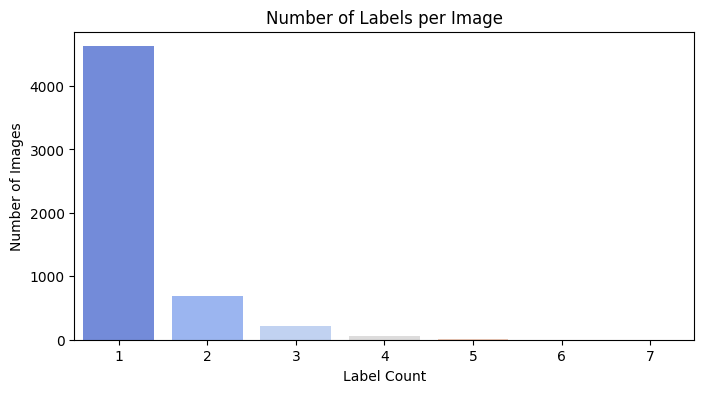

In [15]:
# Plot class distribution
plt.figure(figsize=(12,6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='magma')
plt.xticks(rotation=45)
plt.title("Disease Frequency")
plt.ylabel("Number of Images")
plt.show()


# Multi-label frequency (number of labels per image)
df['Num_Labels'] = df['Finding Labels'].apply(len)
multi_label_counts = df['Num_Labels'].value_counts().sort_index()
print("\nMulti-Label Distribution:")
print(multi_label_counts)
plt.figure(figsize=(8,4))
sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values, palette='coolwarm')
plt.title("Number of Labels per Image")
plt.xlabel("Label Count")
plt.ylabel("Number of Images")
plt.show()

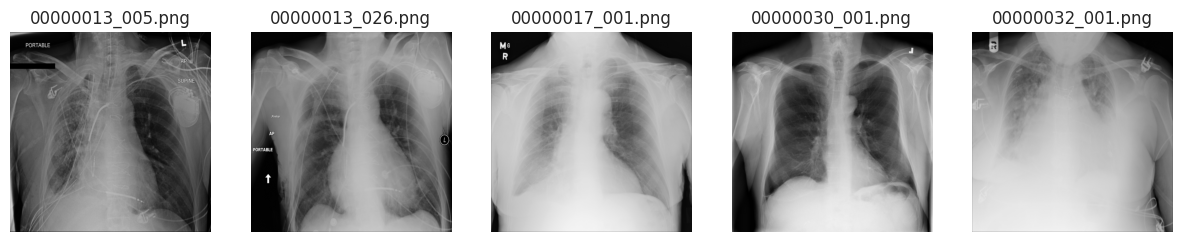

In [79]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_dir = '/content/sample_chest_xray_data/sample/sample/images'

# Get all image filenames
image_files = sorted(os.listdir(image_dir))[:5]  # First 5 images

# Plot images
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(img_file)
    plt.axis('off')
plt.show()

**Plot a processed image**

In [81]:
# Step 3: Prepare for Image Loading
# Add full image paths (assuming a structure)
df['Image Path'] = df['Image Path'].apply(lambda x: os.path.join('/content/sample_chest_xray_data/sample/sample/images'
, x))

# Example check (modify path if different)
print("\nSample Image Paths:")
print(df['Image Path'].head())


Sample Image Paths:
0    /content/sample_chest_xray_data/sample/images/...
1    /content/sample_chest_xray_data/sample/images/...
2    /content/sample_chest_xray_data/sample/images/...
3    /content/sample_chest_xray_data/sample/images/...
4    /content/sample_chest_xray_data/sample/images/...
Name: Image Path, dtype: object


The dimensions of the image are 224 pixels width and 224 pixels height
The maximum pixel value is 2.0758 and the minimum is -2.9856
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


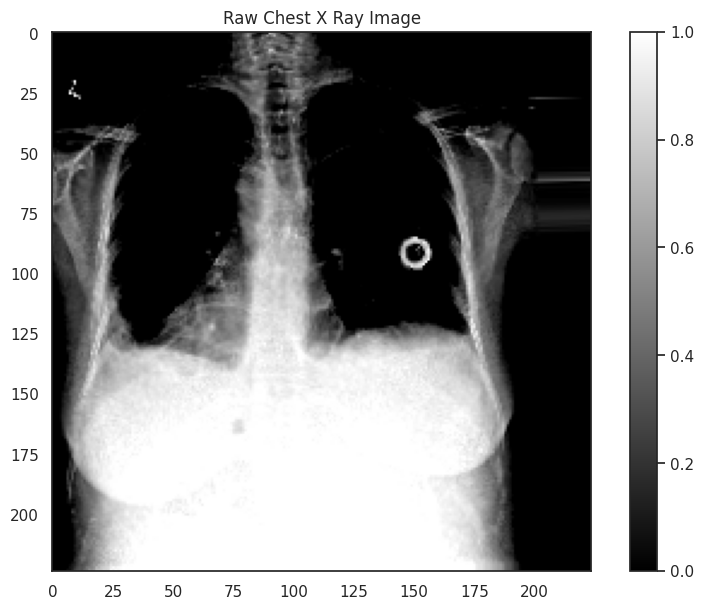

In [ ]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [82]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 224, 224, 3) (224, 224, 3)
(1024, 1024)


In [83]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequencies for each class.

    Args:
        labels (np.array): binary label matrix (num_samples x num_classes)

    Returns:
        positive_frequencies (np.array)
        negative_frequencies (np.array)
    """
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = (N - np.sum(labels, axis=0)) / N
    return positive_frequencies, negative_frequencies


# labels = train_generator.class_indices  # class names - Remove this line
# labels = list(labels.keys())  # convert dict to list of label names - Remove this line

# Assume 'labels' list is already defined in a previous cell
# Compute frequencies
freq_pos, freq_neg = compute_class_freqs(np.array(train_generator.labels))
print(freq_pos)

[0.08715596 0.02624873 0.03899083 0.0206422  0.11569827 0.02268094
 0.01452599 0.00254842 0.17431193 0.04918451 0.05759429 0.03109072
 0.01095821 0.05020387]


**Class Imbalance**

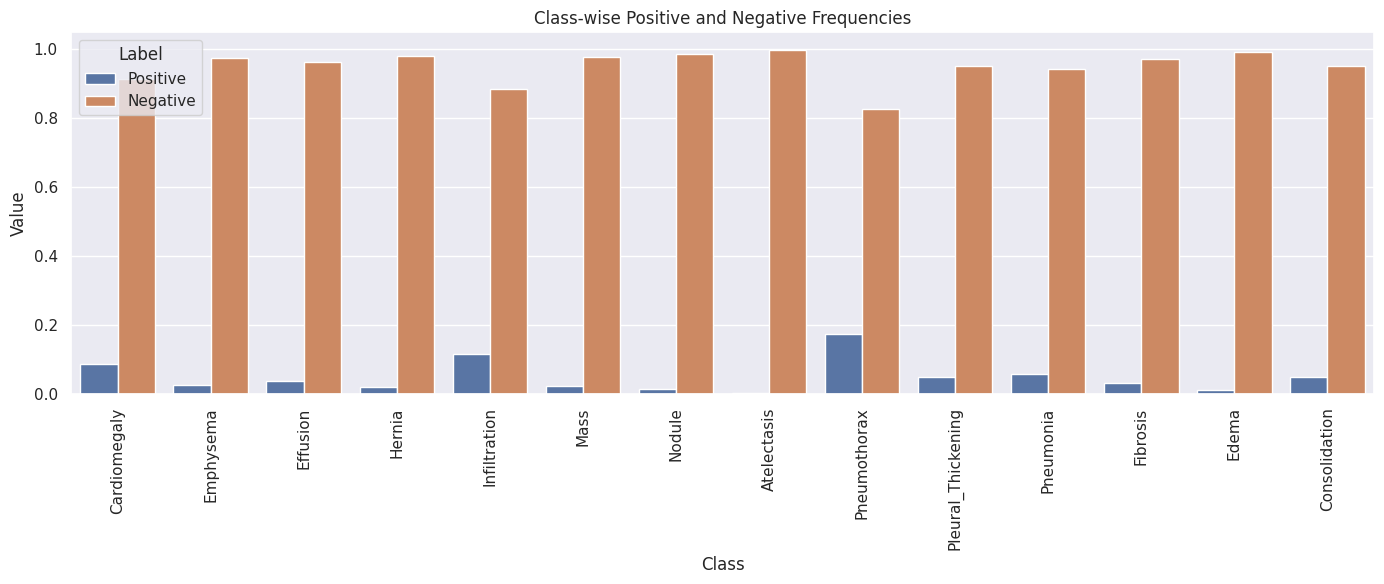

In [84]:
# Create a DataFrame for seaborn for positive frequencies
data = pd.DataFrame({
    "Class": labels,
    "Label": "Positive",
    "Value": freq_pos # Assuming freq_pos is defined in a previous cell
})

# Create a DataFrame for negative frequencies
negative_data = pd.DataFrame({
    "Class": labels,
    "Label": "Negative",
    "Value": freq_neg # Assuming freq_neg is defined in a previous cell
})

# Concatenate the two DataFrames
data = pd.concat([data, negative_data], ignore_index=True) # Corrected to use pd.concat

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.xticks(rotation=90)
plt.title("Class-wise Positive and Negative Frequencies")
plt.tight_layout()
plt.show()

**Compute Weighted Contributions**

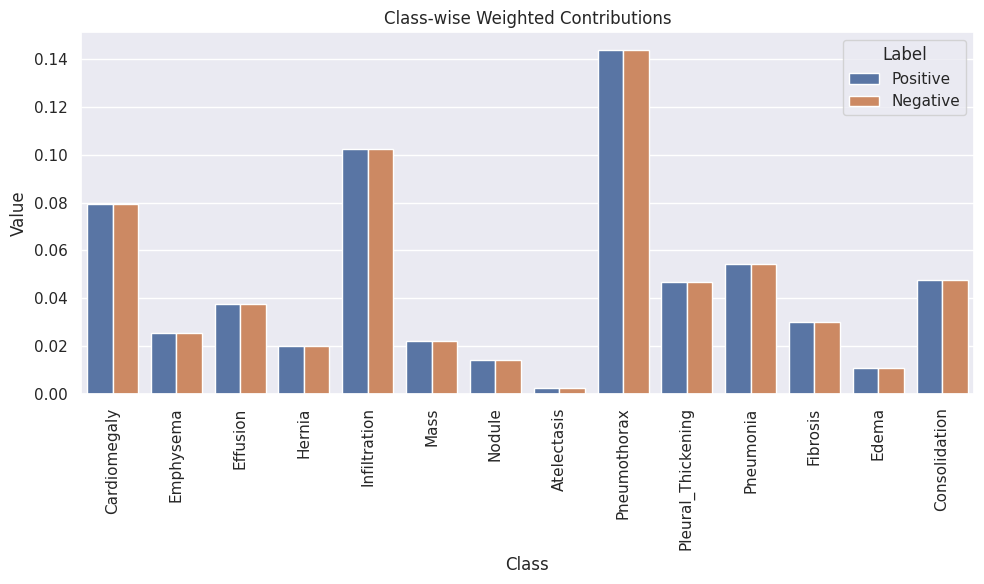

In [86]:
# Assign pos/neg weights (inversely proportional to frequency)
pos_weights = freq_neg
neg_weights = freq_pos

# Contribution from positive and negative examples
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights


import pandas as pd # Added import for pandas
import matplotlib.pyplot as plt # Added import for matplotlib.pyplot
import seaborn as sns # Added import for seaborn
import numpy as np # Added import for numpy

data_contrib = pd.DataFrame({
    "Class": labels,
    "Label": "Positive",
    "Value": pos_contribution # Assuming pos_contribution is defined
})

# Create a DataFrame for negative contributions
negative_data_contrib = pd.DataFrame({
    "Class": labels,
    "Label": "Negative",
    "Value": neg_contribution # Assuming neg_contribution is defined
})

# Concatenate the two DataFrames
data_contrib = pd.concat([data_contrib, negative_data_contrib], ignore_index=True) # Corrected to use pd.concat


# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Value", hue="Label", data=data_contrib)
plt.xticks(rotation=90)
plt.title("Class-wise Weighted Contributions")
plt.tight_layout()
plt.show()

Loading and cleaning data...
Train samples: 3924, Validation samples: 841, Test samples: 841

Calculating robust class weights for imbalanced data...
Calculated Positive Class Weights (applied to positive examples): {0: np.float64(5.7368421052631575), 1: np.float64(19.04854368932039), 2: np.float64(12.823529411764707), 3: np.float64(24.22222222222222), 4: np.float64(4.3215859030837), 5: np.float64(22.04494382022472), 6: np.float64(34.421052631578945), 7: np.float64(196.2), 8: np.float64(2.8684210526315788), 9: np.float64(10.16580310880829), 10: np.float64(8.68141592920354), 11: np.float64(16.081967213114755), 12: np.float64(45.627906976744185), 13: np.float64(9.959390862944163)}
Found 3924 validated image filenames.
Found 841 validated image filenames.
Found 841 validated image filenames.

--- PHASE 1: Training Classification Head ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
123/123 ━━━━━━━━━━━━━━━━━━━━ 952s 8s/step - auc: 0.4961 - loss: 2.7784 - val_auc: 0.5933 - val_loss: 0.1878 - learning_rate: 0.0010
Epoch 2/3
123/123 ━━━━━━━━━━━━━━━━━━━━ 918s 7s/step - auc: 0.5396 - loss: 2.0123 - val_auc: 0.6231 - val_loss: 0.1775 - learning_rate: 0.0010
Epoch 3/3
123/123 ━━━━━━━━━━━━━━━━━━━━ 950s 8s/step - auc: 0.5736 - loss: 1.9144 - val_auc: 0.6443 - val_loss: 0.1775 - learning_rate: 0.0010

--- PHASE 2: Fine-Tuning DenseNet ---
Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 929s 7s/step - auc: 0.5782 - loss: 1.8779 - val_auc: 0.6479 - val_loss: 0.1752
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 907s 7s/step - auc: 0.5863 - loss: 1.9485 - val_auc: 0.6462 - val_loss: 0.1740
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 923s 7s/step - auc: 0.5876 - loss: 1.9902 - val_auc: 0.6474 - val_loss: 0.1732
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 908s 7s/step - auc: 0.6097 - loss: 1.8648 - val_auc: 0.6485 - val_loss: 0.1727
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 911s 7s/step - auc: 0.59

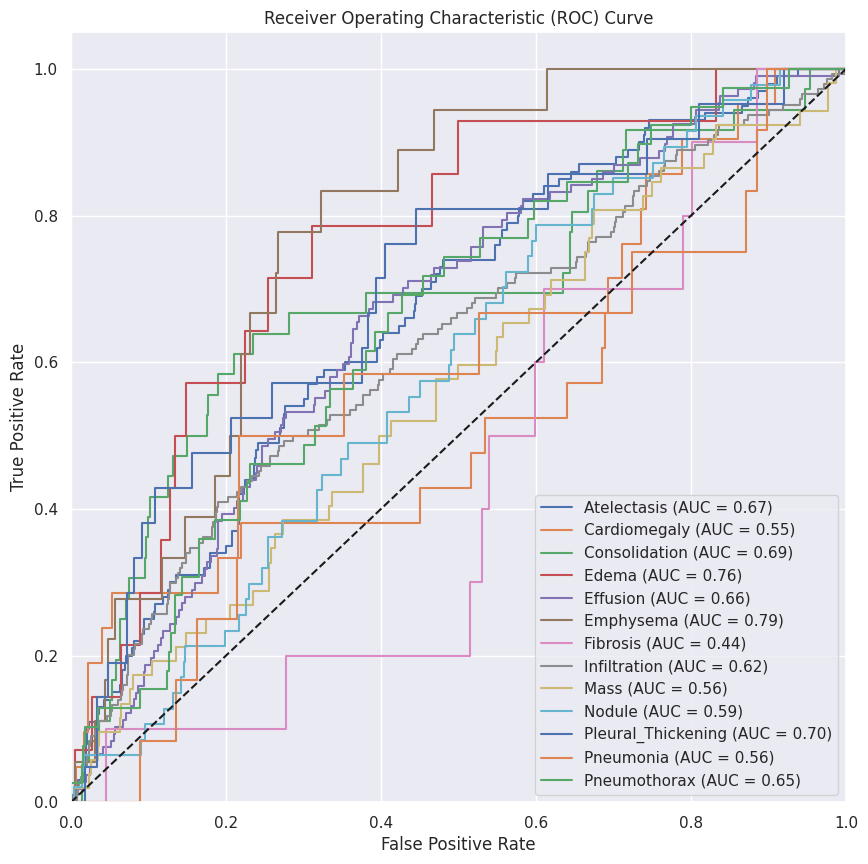

In [62]:
# ---- 1. Setup and Configuration
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.densenet import preprocess_input # CRITICAL: ImageNet Preprocessing

# ---- Configuration
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE_1 = 3 # Train head only
EPOCHS_PHASE_2 = 5 # Fine-tune entire model
LEARNING_RATE_PHASE_1 = 1e-3
LEARNING_RATE_PHASE_2 = 1e-5

# ---- Define dataset paths (Assume the user has already downloaded and unzipped the sample)
IMAGE_DIR = "/content/sample_chest_xray_data/sample/images"
CSV_PATH = "/content/sample_chest_xray_data/sample_labels.csv"

MODEL_SAVE_PATH = "/content/nih_chest_xray_optimized_model.keras"

# ---- Define all 14 pathology labels
LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]


# 2. ---- Data Loading, Cleaning, and Splitting
print("Loading and cleaning data...")
df = pd.read_csv(CSV_PATH)

# --- Data Cleaning (Crucial for Multi-label) ---
# 1. Binarize labels
df['Finding Labels'] = df['Finding Labels'].apply(
    lambda x: x.replace('No Finding', '').strip()
)
for label in LABELS:
    # This guarantees the creation of the binary column in df
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

# 2. Create full image path and drop missing files
df.rename(columns={'Image Index': 'Image Path'}, inplace=True)
df['Image Path'] = df['Image Path'].apply(lambda x: os.path.join(IMAGE_DIR, x))
df = df[df["Image Path"].apply(os.path.exists)]

# 3. ---- Train / Val / Test split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")


# 3. ---- Handling Data Imbalance (Robust Class Weighting)
print("\nCalculating robust class weights for imbalanced data...")

# Calculate the frequency of positive examples for each label in the training set
pos_counts = train_df[LABELS].sum()
neg_counts = len(train_df) - pos_counts
total_samples = len(train_df)

# Calculate the weight for the positive class (inverse frequency weighting)
simple_class_weights = {}

# Iterate over the LABELS list and use try/except for robustness against missing or zero counts
for i, label in enumerate(LABELS):
    try:
        count_pos = pos_counts[label]

        # Calculate weight: Total samples / (2 * Count of the positive class)
        # The '2' normalizes the weights so the average weight across classes is 1.0
        weight_1 = total_samples / (2.0 * count_pos)

        # We assign the weight for the positive class (1) to the label index (i).
        # This prioritizes the rare positive cases.
        simple_class_weights[i] = weight_1

    except KeyError:
        # If the label is not found in the counts series, skip it or assign a neutral weight.
        # Since the column should exist, if it's not in the counts series, something is wrong. We assign a default.
        print(f"Warning: Label '{label}' not found in training data counts. Assigning weight 1.0.")
        simple_class_weights[i] = 1.0

    except ZeroDivisionError:
        # FIX for zero counts: If a rare disease has 0 positive samples in the train split.
        # Assign a very high, fixed weight (e.g., 100) to ensure the model sees it if it appears later.
        print(f"Warning: Label '{label}' has 0 positive samples in the training set. Assigning high weight (100.0).")
        simple_class_weights[i] = 100.0

print(f"Calculated Positive Class Weights (applied to positive examples): {simple_class_weights}")


# ---- 4. Image Generators (ImageNet Preprocessing)
def densenet_preprocess(image):
    return preprocess_input(image)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=densenet_preprocess # Use ImageNet normalization
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess # Use ImageNet normalization
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='Image Path', y_col=LABELS,
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='raw', color_mode='rgb'
)
valid_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df, x_col='Image Path', y_col=LABELS,
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='raw', color_mode='rgb', shuffle=False
)
test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='Image Path', y_col=LABELS,
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='raw', color_mode='rgb', shuffle=False
)


# ---- 5. Model Building and Phase 1 Training (Train Head Only)
def build_model(trainable_base=False):
    base = DenseNet121(weights="imagenet", include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    base.trainable = trainable_base
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    outputs = Dense(len(LABELS), activation="sigmoid")(x)
    model = Model(inputs=base.input, outputs=outputs)
    return model

# --- PHASE 1: Train Head Only ---
model = build_model(trainable_base=False)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE_1),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True, num_labels=len(LABELS))]
)

callbacks_p1 = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5),
]

print("\n--- PHASE 1: Training Classification Head ---")
history_p1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_PHASE_1,
    callbacks=callbacks_p1,
    class_weight=simple_class_weights # Apply class weights
)


# ---- 6. Phase 2 Training (Fine-Tuning)
# --- PHASE 2: Fine-Tuning the Whole Model ---
for layer in model.layers:
    if "densenet121" in layer.name: # Find the DenseNet base layer
        layer.trainable = True
        # Fine-tune the last 100 layers, keeping the initial layers frozen
        for sub_layer in layer.layers[:-100]:
            sub_layer.trainable = False
        break

# Recompile with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE_2),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True, num_labels=len(LABELS))]
)

callbacks_p2 = [
    EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor="val_auc", mode="max") # Save based on AUC
]

print("\n--- PHASE 2: Fine-Tuning DenseNet ---")
history_p2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_PHASE_2,
    callbacks=callbacks_p2,
    class_weight=simple_class_weights # Apply class weights
)

# Load the best model saved from Phase 2
model = tf.keras.models.load_model(
    MODEL_SAVE_PATH,
    custom_objects={"auc": tf.keras.metrics.AUC(name="auc", multi_label=True, num_labels=len(LABELS))}
)


#  ---- 7. Prediction and Evaluation
test_generator.reset()
y_true = test_generator.labels

print("\nPredicting on test set...")
y_prob = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1, verbose=1)
y_prob = y_prob[:len(y_true)]

# --- Evaluation Metrics ---
print("\n--- Final Evaluation Metrics ---")

# 1. Per-class AUC-ROC
auc_roc_vals = {}
for i, lbl in enumerate(LABELS):
    if len(np.unique(y_true[:, i])) > 1:
        auc_val = roc_auc_score(y_true[:, i], y_prob[:, i])
        auc_roc_vals[lbl] = auc_val
    else:
        auc_roc_vals[lbl] = np.nan

macro_avg_auc = np.nanmean(list(auc_roc_vals.values()))
print(f"Overall Macro-Average AUC: {macro_avg_auc:.4f}")
print("Per-class AUC-ROC:")
for lbl, auc_val in auc_roc_vals.items():
    print(f"  {lbl}: {auc_val:.4f}" if not np.isnan(auc_val) else f"  {lbl}: NA (Single class in test set)")

# 2. Classification Report (using 0.5 threshold)
y_pred = (y_prob > 0.5).astype(int)
report = classification_report(y_true, y_pred, target_names=LABELS, zero_division=0)
print("\nClassification Report (Threshold 0.5):\n", report)


#  ----8. Visualization (ROC Curves)
def plot_roc_curves(labels, predicted_vals, y_true):
    plt.figure(figsize=(10, 10))
    for i in range(len(labels)):
        if len(np.unique(y_true[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_true[:, i], predicted_vals[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')
        else:
            print(f"Skipping ROC curve for {labels[i]} (requires multiple classes).")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(LABELS, y_prob, y_true)

**Mount Drive, Save the Model into drive:**

In [64]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory where you want to save the model
# This folder will be created inside your "My Drive"
DRIVE_DIR = '/content/drive/MyDrive/ChestXRay_Models'

# Create the directory if it doesn't exist
if not os.path.exists(DRIVE_DIR):
    os.makedirs(DRIVE_DIR)

print(f"Drive mounted and save directory ready at: {DRIVE_DIR}")

Mounted at /content/drive
Drive mounted and save directory ready at: /content/drive/MyDrive/ChestXRay_Models


# **Prediction**

In [65]:
import tensorflow as tf

# --- Configuration (Must match training config) ---
LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

# Temporary path where the best model was saved during training
TEMP_MODEL_PATH = "/content/nih_chest_xray_optimized_model.keras"

# Permanent path in Google Drive
FINAL_MODEL_PATH = os.path.join(DRIVE_DIR, 'optimized_densenet_chest_xray.keras')

try:
    # 1. Load the model from the temporary path (where the best AUC version is stored)
    loaded_model = tf.keras.models.load_model(
        TEMP_MODEL_PATH,
        custom_objects={"auc": tf.keras.metrics.AUC(name="auc", multi_label=True, num_labels=len(LABELS))}
    )

    # 2. Save the model to the permanent Drive path
    tf.keras.models.save_model(loaded_model, FINAL_MODEL_PATH)

    print(f"\n✅ Model successfully saved to Google Drive at: {FINAL_MODEL_PATH}")
    print("You can now close the Colab session. The model is persistent.")

except Exception as e:
    print(f"Could not save model. Ensure the training completed successfully and the temporary file exists. Error: {e}")


✅ Model successfully saved to Google Drive at: /content/drive/MyDrive/ChestXRay_Models/optimized_densenet_chest_xray.keras
You can now close the Colab session. The model is persistent.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Attempting to load persistent model from: /content/drive/MyDrive/ChestXRay_Models/optimized_densenet_chest_xray.keras
Model loaded successfully from Google Drive.


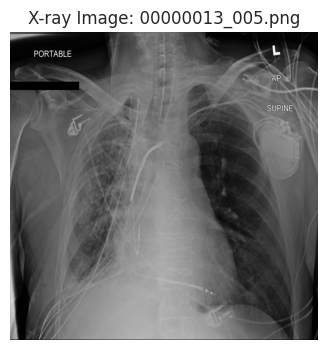


--- Model Prediction Results ---
Highest Confidence Prediction: Edema (21.98%)

All Predictions:
| Disease            |   Confidence (%) |
|:-------------------|-----------------:|
| Edema              |            21.98 |
| Effusion           |            14.19 |
| Infiltration       |            14.00 |
| Consolidation      |            10.40 |
| Mass               |             6.38 |
| Emphysema          |             5.41 |
| Atelectasis        |             5.19 |
| Nodule             |             3.13 |
| Pneumothorax       |             2.59 |
| Cardiomegaly       |             2.58 |
| Pleural_Thickening |             1.29 |
| Pneumonia          |             1.16 |
| Fibrosis           |             0.94 |
| Hernia             |             0.22 |


In [66]:
# Prediction Setup for Persistent Model Loading

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os

# --- Configuration (Must match training config) ---
TARGET_SIZE = (224, 224)
LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

# --- 1. Mount Drive (Necessary for every new session) ---
drive.mount('/content/drive')
DRIVE_DIR = '/content/drive/MyDrive/ChestXRay_Models'
FINAL_MODEL_PATH = os.path.join(DRIVE_DIR, 'optimized_densenet_chest_xray.keras')

# --- 2. Define Helper Functions ---
def prepare_image_for_prediction(img_path):
    """Loads, resizes, and preprocesses a single image for DenseNet."""
    img = image.load_img(img_path, target_size=TARGET_SIZE, color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) # CRITICAL: DenseNet Normalization
    return img_array

def predict_new_image(model, img_path):
    """Makes a prediction on a new image and formats the results."""
    if model is None:
        print("Model is not loaded. Cannot make prediction.")
        return

    processed_image = prepare_image_for_prediction(img_path)
    prediction = model.predict(processed_image, verbose=0)[0]

    # Format results
    results = pd.DataFrame({
        'Disease': LABELS,
        'Confidence (%)': prediction * 100
    }).sort_values(by='Confidence (%)', ascending=False).reset_index(drop=True)

    # Display the image
    img = image.load_img(img_path)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.title(f"X-ray Image: {img_path.split('/')[-1]}")
    plt.axis('off')
    plt.show()

    print("\n--- Model Prediction Results ---")

    # Output the key information
    top_disease = results.iloc[0]

    print(f"Highest Confidence Prediction: {top_disease['Disease']} ({top_disease['Confidence (%)']:.2f}%)")
    print("\nAll Predictions:")
    print(results.to_markdown(index=False, floatfmt=".2f"))

# --- 3. Load the Model from Drive ---
loaded_model = None
try:
    print(f"Attempting to load persistent model from: {FINAL_MODEL_PATH}")
    loaded_model = tf.keras.models.load_model(
        FINAL_MODEL_PATH,
        custom_objects={"auc": tf.keras.metrics.AUC(name="auc", multi_label=True, num_labels=len(LABELS))}
    )
    print("Model loaded successfully from Google Drive.")
except Exception as e:
    print(f"Error loading model from Drive. Ensure Step 2 was completed. Error: {e}")

# --- 4. Example Usage (Replace with your new image path) ---
# NOTE: This example uses a file path you had in the previous runs.
# If you are in a new session, you'll need to upload a new image or use a file path that exists.
NEW_IMAGE_PATH = "/content/sample_chest_xray_data/sample/sample/images/00000013_005.png"

# Make the prediction
if loaded_model:
    predict_new_image(loaded_model, NEW_IMAGE_PATH)

**Upload the image & check prediction results:**

Please select the X-ray image file you wish to upload...


Saving tes.jpg to tes.jpg

File uploaded successfully. Path: /content/tes.jpg


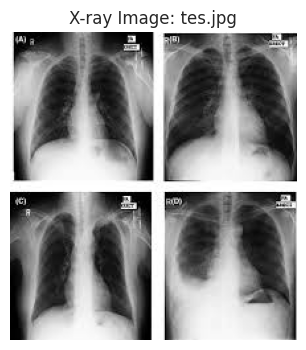


--- Model Prediction Results ---
Highest Confidence Prediction: Fibrosis (51.82%)

All Predictions:
| Disease            |   Confidence (%) |
|:-------------------|-----------------:|
| Fibrosis           |            51.82 |
| Pleural_Thickening |             7.69 |
| Nodule             |             4.46 |
| Cardiomegaly       |             3.64 |
| Effusion           |             3.09 |
| Atelectasis        |             2.85 |
| Infiltration       |             2.47 |
| Consolidation      |             2.34 |
| Mass               |             1.48 |
| Emphysema          |             1.43 |
| Pneumonia          |             1.35 |
| Edema              |             1.06 |
| Pneumothorax       |             1.04 |
| Hernia             |             0.19 |


In [73]:
import numpy as np
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from google.colab import files

# --- 1. UPLOAD THE IMAGE ---
print("Please select the X-ray image file you wish to upload...")
uploaded = files.upload()

# --- 2. GET THE FILE PATH ---
# The keys of the 'uploaded' dictionary are the uploaded file names.
if uploaded:
    # Get the name of the first (and likely only) uploaded file
    uploaded_file_name = next(iter(uploaded))
    # In Colab, the file is saved to the current working directory (/content/)
    NEW_IMAGE_PATH = f"/content/{uploaded_file_name}"
    print(f"\nFile uploaded successfully. Path: {NEW_IMAGE_PATH}")

    # --- 3. RUN THE PREDICTION ---

    # You need the predict_new_image function defined in the previous response:
    def prepare_image_for_prediction(img_path):
        """Loads, resizes, and preprocesses a single image for DenseNet."""
        TARGET_SIZE = (224, 224)
        img = image.load_img(img_path, target_size=TARGET_SIZE, color_mode='rgb')
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array) # CRITICAL: DenseNet Normalization
        return img_array

    def predict_new_image(model, img_path):
        """Makes a prediction on a new image and formats the results."""
        if model is None:
            print("Model is not loaded. Cannot make prediction.")
            return

        processed_image = prepare_image_for_prediction(img_path)
        prediction = model.predict(processed_image, verbose=0)[0]

        # Format results
        results = pd.DataFrame({
            'Disease': LABELS,
            'Confidence (%)': prediction * 100
        }).sort_values(by='Confidence (%)', ascending=False).reset_index(drop=True)

        # Display the image
        img = image.load_img(img_path)
        plt.figure(figsize=(8, 4))
        plt.imshow(img)
        plt.title(f"X-ray Image: {img_path.split('/')[-1]}")
        plt.axis('off')
        plt.show()

        print("\n--- Model Prediction Results ---")

        top_disease = results.iloc[0]

        print(f"Highest Confidence Prediction: {top_disease['Disease']} ({top_disease['Confidence (%)']:.2f}%)")
        print("\nAll Predictions:")
        print(results.to_markdown(index=False, floatfmt=".2f"))

    # Execute the prediction
    predict_new_image(loaded_model, NEW_IMAGE_PATH)

else:
    print("No file was uploaded.")

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from google.colab import drive, files
import os

# --- 1. Configuration (MUST MATCH TRAINING) ---
TARGET_SIZE = (224, 224)
LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]
# Path where you saved the model
DRIVE_DIR = '/content/drive/MyDrive/ChestXRay_Models'
FINAL_MODEL_PATH = os.path.join(DRIVE_DIR, 'optimized_densenet_chest_xray.keras')
# Name of the last convolutional layer in DenseNet121
LAST_CONV_LAYER_NAME = 'conv5_block16_concat'

# --- 2. Helper Functions ---

def prepare_image_for_prediction(img_path):
    """Loads, resizes, and preprocesses a single image for DenseNet."""
    img = image.load_img(img_path, target_size=TARGET_SIZE, color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) # CRITICAL: DenseNet Normalization
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index):
    """Computes the Grad-CAM heatmap."""
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_heatmap(img_path, heatmap):
    """Superimposes the heatmap onto the original image."""
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

def predict_and_run_gradcam(model, img_path):
    """Runs prediction, prints results, and generates Grad-CAM for the top prediction."""
    if model is None:
        print("Model is not loaded. Cannot proceed.")
        return

    # --- Prediction ---
    processed_image = prepare_image_for_prediction(img_path)
    prediction = model.predict(processed_image, verbose=0)[0]

    results = pd.DataFrame({
        'Disease': LABELS,
        'Confidence (%)': prediction * 100
    }).sort_values(by='Confidence (%)', ascending=False).reset_index(drop=True)

    # Display initial prediction results
    print("\n--- Model Prediction Results ---")
    top_disease = results.iloc[0]
    print(f"Highest Confidence Prediction: {top_disease['Disease']} ({top_disease['Confidence (%)']:.2f}%)")
    print("\nAll Predictions:")
    print(results.to_markdown(index=False, floatfmt=".2f"))

    # Determine target for Grad-CAM (the highest prediction)
    TARGET_DISEASE = top_disease['Disease']
    TARGET_CONFIDENCE = top_disease['Confidence (%)']
    target_index = LABELS.index(TARGET_DISEASE)

    # --- Grad-CAM Execution ---
    print(f"\n--- Generating Grad-CAM for: {TARGET_DISEASE} ---")

    try:
        heatmap = make_gradcam_heatmap(
            processed_image,
            model,
            LAST_CONV_LAYER_NAME,
            pred_index=target_index
        )
        gradcam_image = superimpose_heatmap(img_path, heatmap)

        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Original Image
        axes[0].imshow(image.load_img(img_path))
        axes[0].set_title("Original X-Ray")
        axes[0].axis("off")

        # Grad-CAM Image
        axes[1].imshow(gradcam_image)
        axes[1].set_title(f"Grad-CAM for: {TARGET_DISEASE} ({TARGET_CONFIDENCE:.2f}%)")
        axes[1].axis("off")

        plt.show()

    except Exception as e:
        print(f"An error occurred during Grad-CAM generation: {e}")

In [ ]:
# --- 3. Execution Block ---

# A. Mount Drive (Essential for new session)
print("1. Mounting Google Drive...")
drive.mount('/content/drive')

# B. Load the Model
loaded_model = None
print("\n2. Loading Model from Google Drive...")
try:
    loaded_model = tf.keras.models.load_model(
        FINAL_MODEL_PATH,
        custom_objects={"auc": tf.keras.metrics.AUC(name="auc", multi_label=True, num_labels=len(LABELS))}
    )
    print(f"✅ Model loaded successfully from: {FINAL_MODEL_PATH}")
except Exception as e:
    print(f"❌ Error loading model from Drive. Please ensure the path is correct and the model was saved. Error: {e}")

# **Interpreting Deep Learning Models**

# **GradCAM**


3. Please upload the X-ray image file you wish to test.


Saving test_2.jpg to test_2.jpg

File uploaded successfully. Starting analysis on: test_2.jpg

--- Model Prediction Results ---
Highest Confidence Prediction: Fibrosis (57.75%)

All Predictions:
| Disease            |   Confidence (%) |
|:-------------------|-----------------:|
| Fibrosis           |            57.75 |
| Pneumothorax       |            11.76 |
| Nodule             |            11.54 |
| Infiltration       |            10.67 |
| Edema              |            10.44 |
| Atelectasis        |             9.24 |
| Pleural_Thickening |             8.99 |
| Consolidation      |             8.16 |
| Pneumonia          |             7.72 |
| Mass               |             7.33 |
| Emphysema          |             6.86 |
| Cardiomegaly       |             6.67 |
| Effusion           |             3.11 |
| Hernia             |             2.51 |

--- Generating Grad-CAM for: Fibrosis ---


/tmp/ipython-input-380387492.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


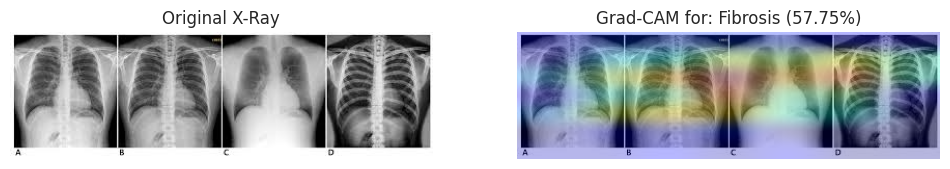

In [78]:
# C. Interactive Upload and Prediction
if loaded_model:
    print("\n3. Please upload the X-ray image file you wish to test.")

    try:
        uploaded = files.upload()

        if uploaded:
            uploaded_file_name = next(iter(uploaded))
            NEW_IMAGE_PATH = f"/content/{uploaded_file_name}"
            print(f"\nFile uploaded successfully. Starting analysis on: {uploaded_file_name}")

            # Run the prediction and Grad-CAM
            predict_and_run_gradcam(loaded_model, NEW_IMAGE_PATH)

        else:
            print("No file was uploaded. Analysis aborted.")

    except Exception as e:
        print(f"An error occurred during file upload or analysis: {e}")

Test above